In [1]:
import sys
import os

import keras
import sklearn as sk
import tensorflow as tf
import platform
import numpy as np
import random
import time

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

2024-06-10 22:40:31.790302: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-10 22:40:31.830443: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 22:40:31.830482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 22:40:31.832982: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-10 22:40:31.844956: I tensorflow/core/platform/cpu_feature_guar

Python Platform: Linux-5.15.146.1-microsoft-standard-WSL2-x86_64-with-glibc2.35
Tensor Flow Version: 2.15.0
Keras Version: 2.15.0

Python 3.11.0rc1 (main, Aug 12 2022, 10:02:14) [GCC 11.2.0]
Scikit-Learn 1.5.0
GPU is available


2024-06-10 22:40:33.770024: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 22:40:33.777581: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 22:40:33.777619: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
SEED = 42

os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # new flag present in tf 2.0+
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define the path to your dataset
data_dir = 'data/train/train_six_label'
test_dir = "data/test/test_six_label"
tflite_model_path = 'models/model.tflite'
plot_dir = 'plots'

# Define the class names
class_names = ["blue", "white", "red", "fail"]

GRAYSCALE = False

image_size = (240, 240)
image_shape = image_size + (1 if GRAYSCALE else 3,)
BATCH_SIZE = 32

# Map folder names to output labels
folder_to_label = {
    "blue": "blue",
    "blue_fail": "fail",
    "red": "red",
    "red_fail": "fail",
    "white": "white",
    "white_fail": "fail"
}

# Create a lookup table for folder names to output labels
keys = tf.constant(list(folder_to_label.keys()))
values = tf.constant([class_names.index(folder_to_label[key]) for key in folder_to_label.keys()])
table = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(keys, values), default_value=3)

# Define another table to map folder names to color indices
color_values = tf.constant([0 if "blue" in key else 1 if "white" in key else 2 for key in folder_to_label.keys()])
color_table = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(keys, color_values), default_value=-1)

@tf.function
def process_label(label):
    # Convert the numeric label to the corresponding folder name
    folder_name = tf.gather(keys, label)
    
    # Look up the output label from the folder name
    mapped_label = table.lookup(folder_name)
    
    # One-hot encode the output label
    one_hot_label = tf.one_hot(mapped_label, len(class_names))
    
    # Look up the color index from the folder name
    color_index = color_table.lookup(folder_name)
    
    return one_hot_label, color_index

# Load the dataset
dataset = image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=image_size,
    shuffle=True,
    color_mode='grayscale' if GRAYSCALE else 'rgb'
)

test_ds = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=image_size,
    shuffle=True,
    color_mode='grayscale' if GRAYSCALE else 'rgb'
)

# Process the dataset
@tf.function
def process_image_label(image, label):
    one_hot_label, color_index = process_label(label)
    return {"image_input": image, "color_index_input": color_index}, one_hot_label

dataset = dataset.map(process_image_label)

# Split dataset into training and validation
val_size = int(0.2 * len(list(dataset)))
train_ds = dataset.skip(val_size)
val_ds = dataset.take(val_size)

test_ds = test_ds.map(process_image_label)

2024-06-10 22:40:33.868133: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 22:40:33.868255: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 22:40:33.868294: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 22:40:34.092470: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-10 22:40:34.092510: I external/local_xla/xla/stream_executor

Found 840 files belonging to 6 classes.
Found 354 files belonging to 6 classes.


In [4]:
# Data Augmentation Pipeline

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.Normalization(),
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set.
  if augment:
        ds = ds.map(lambda x, y: ({"image_input": data_augmentation(x["image_input"], training=True), "color_index_input": x["color_index_input"]}, y), num_parallel_calls=AUTOTUNE)
    

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=True)

In [5]:
for x, y in train_ds.take(1):
    # Gather all unique color indices
    color_indices = tf.unique(tf.reshape(x["color_index_input"], [-1]))[0]
    print(color_indices)

tf.Tensor([2 1 0], shape=(3,), dtype=int32)


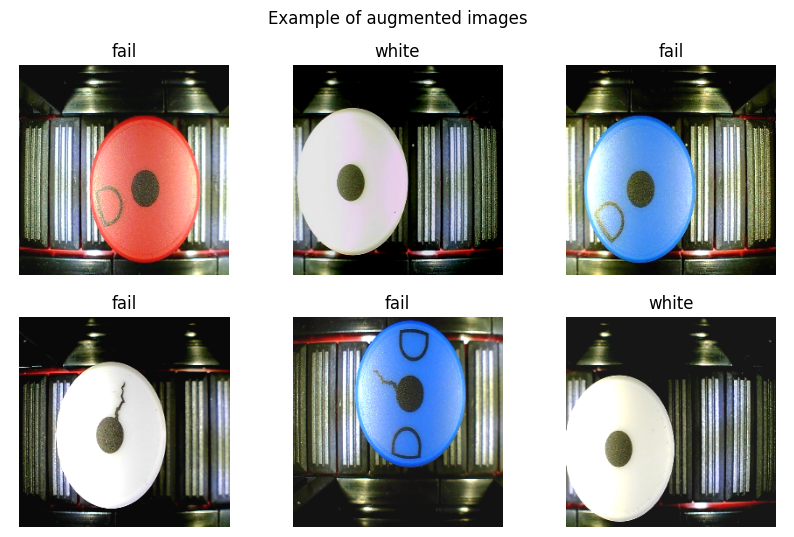

In [6]:
# Print example images
import matplotlib.pyplot as plt

for x, y in train_ds.take(1):
    images = x["image_input"]
    labels = y

    plt.figure(figsize=(10, 6))
    plt.title("Example of augmented images", pad=30)
    plt.axis("off")
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i])])
        plt.axis("off")

In [7]:
from tensorflow.keras.layers import Input, Flatten, Dense, Concatenate, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0, EfficientNetV2B0

# Define the number of classes
num_classes = len(class_names)

def rgb_to_grayscale(x):
    """
    Convert RGB images to grayscale.
    """
    return tf.image.rgb_to_grayscale(x)

# Define the input shapes
color_index_input_shape = ()

def create_model(image_shape, architecture=None):
    
    # Define the image input
    image_input = Input(shape=image_shape, name='image_input')

    # Load EfficientNetB1 pre-trained on ImageNet without the top classification layer
    base_model = architecture(weights='imagenet', include_top=False, input_tensor=image_input, )
   
    # Freeze the base model layers so they are not updated during training
    base_model.trainable = False

    # Define the color index input
    color_index_input = Input(shape=color_index_input_shape, name='color_index_input')

    # Flatten the output of the base model
    x = Flatten()(base_model.output)

    # Color index processing through embedding layer
    embedding_dim = 8
    color_embedding = Embedding(input_dim=4, output_dim=embedding_dim)(color_index_input)
    color_embedding = Flatten()(color_embedding)

    # Concatenate image features and color embedding
    combined = Concatenate()([x, color_embedding])

    # Fully connected layers
    combined = Dense(256, activation='relu')(combined)
    combined = Dense(128, activation='relu')(combined)
    output = Dense(num_classes, activation='softmax')(combined)

    # Define the model
    model = Model(inputs=[image_input, color_index_input], outputs=output)

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

efficient_net = create_model(image_shape, EfficientNetB0)
efficient_net_v2 = create_model(image_shape, EfficientNetV2B0)

def get_model_params(model):
    total_params = model.count_params()
    trainable_params = sum([tf.size(w) for w in model.trainable_weights])
    non_trainable_params = total_params - trainable_params
    return total_params, trainable_params, non_trainable_params

# Get parameters for EfficientNetB0
eff_net_params = get_model_params(efficient_net)

# Get parameters for EfficientNetV2B0
eff_net_v2_params = get_model_params(efficient_net_v2)

# Print the results
print("EfficientNetB0:")
print("Total Params:", eff_net_params[0])
print("Trainable Params:", eff_net_params[1])
print("Non-Trainable Params:", eff_net_params[2])

print("\nEfficientNetV2B0:")
print("Total Params:", eff_net_v2_params[0])
print("Trainable Params:", eff_net_v2_params[1])
print("Non-Trainable Params:", eff_net_v2_params[2])

EfficientNetB0:
Total Params: 25056839
Trainable Params: tf.Tensor(21007268, shape=(), dtype=int32)
Non-Trainable Params: tf.Tensor(4049571, shape=(), dtype=int32)

EfficientNetV2B0:
Total Params: 26926580
Trainable Params: tf.Tensor(21007268, shape=(), dtype=int32)
Non-Trainable Params: tf.Tensor(5919312, shape=(), dtype=int32)


In [8]:
VERBOSE = 1

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=VERBOSE, mode='auto',
    baseline=None, restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=VERBOSE, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0
)

def create_checkpoint(model_name):
    return tf.keras.callbacks.ModelCheckpoint(
        f'models/{model_name}.h5', monitor='val_loss', verbose=VERBOSE, save_best_only=True,
        save_weights_only=False, mode='auto', save_freq='epoch'
    )

In [9]:
# H = model.fit(train_ds, epochs=40, validation_data=val_ds, callbacks=[early_stopping, reduce_lr, checkpoint])

# EfficientNetB0
efficient_net_b0_history = efficient_net.fit(train_ds, epochs=40, validation_data=val_ds, callbacks=[early_stopping, reduce_lr, create_checkpoint("efficient_net")])

# EfficientNetV2B0
efficient_netv2_b0_history = efficient_net_v2.fit(train_ds, epochs=40, validation_data=val_ds, callbacks=[early_stopping, reduce_lr, create_checkpoint("efficient_net_v2")])


Epoch 1/40


2024-06-10 22:40:46.113461: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-06-10 22:40:46.834367: I external/local_xla/xla/service/service.cc:168] XLA service 0xd5ced20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-10 22:40:46.834398: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2024-06-10 22:40:46.838439: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1718059246.895647   65219 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/22 [===========================>..] - ETA: 0s - loss: 6.6681 - accuracy: 0.5494
Epoch 1: val_loss improved from inf to 2.57512, saving model to models/efficient_net.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 9s 163ms/step - loss: 6.3925 - accuracy: 0.5574 - val_loss: 2.5751 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 2/40
22/22 [==============================] - ETA: 0s - loss: 2.7163 - accuracy: 0.7132
Epoch 2: val_loss did not improve from 2.57512
22/22 [==============================] - 2s 47ms/step - loss: 2.7163 - accuracy: 0.7132 - val_loss: 4.5025 - val_accuracy: 0.6938 - lr: 0.0010
Epoch 3/40
22/22 [==============================] - ETA: 0s - loss: 1.6106 - accuracy: 0.7618
Epoch 3: val_loss improved from 2.57512 to 0.71163, saving model to models/efficient_net.h5
22/22 [==============================] - 3s 107ms/step - loss: 1.6106 - accuracy: 0.7618 - val_loss: 0.7116 - val_accuracy: 0.8375 - lr: 0.0010
Epoch 4/40
20/22 [==========================>...] - ETA: 0s - loss: 0.7669 - accuracy: 0.8166
Epoch 4: val_loss did not improve from 0.71163
22/22 [==============================] - 2s 43ms/step - loss: 0.7436 - accuracy: 0.8221 - val_loss: 0

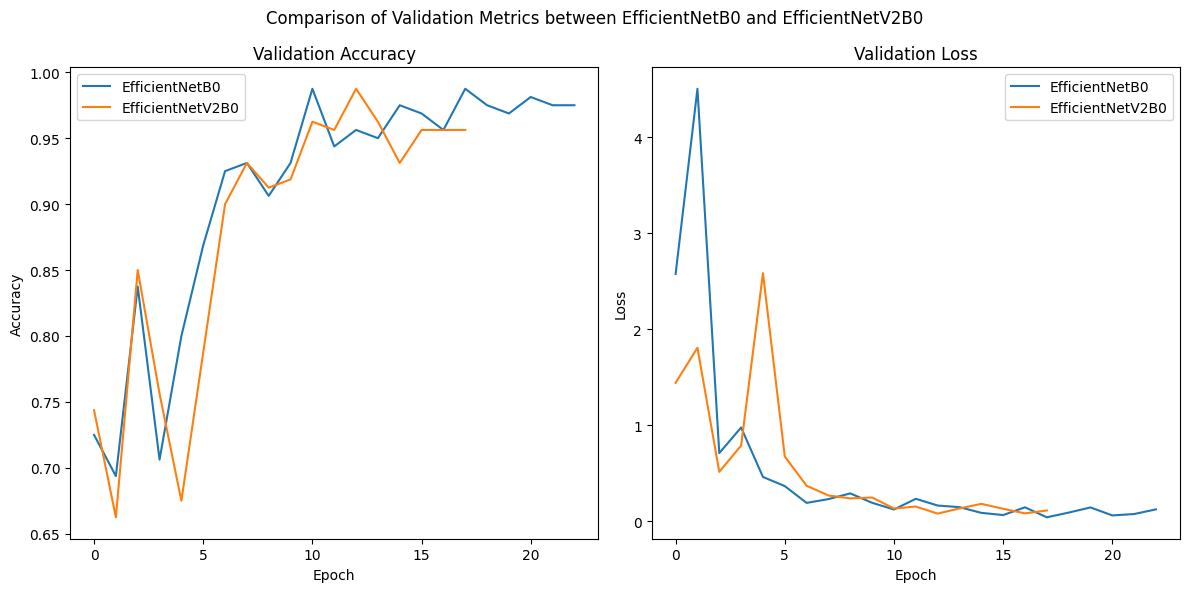

In [10]:
import matplotlib.pyplot as plt

def plot_history(histories, model_names):
    # Plot validation accuracies
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    for i, history in enumerate(histories):
        plt.plot(history.history['val_accuracy'], label=model_names[i])

    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot validation losses
    plt.subplot(1, 2, 2)
    for i, history in enumerate(histories):
        plt.plot(history.history['val_loss'], label=model_names[i])

    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Add a descriptive title to the plot
    plt.suptitle('Comparison of Validation Metrics between EfficientNetB0 and EfficientNetV2B0')

    plt.tight_layout()
    
    # Save the plot
    plt.savefig(os.path.join(plot_dir, 'validation_metrics.png'))

    plt.show()

plot_history([efficient_net_b0_history, efficient_netv2_b0_history], ['EfficientNetB0', 'EfficientNetV2B0'])


In [11]:
# Evaluate both models on the test set
test_loss_efficient_net_b0, test_accuracy_efficient_net_b0 = efficient_net.evaluate(test_ds)
test_loss_efficient_netv2_b0, test_accuracy_efficient_netv2_b0 = efficient_net_v2.evaluate(test_ds)

# Print the test accuracies and losses for both models
print("EfficientNetB0:")
print(f"Test Accuracy: {test_accuracy_efficient_net_b0:.4f}")
print(f"Test Loss: {test_loss_efficient_net_b0:.4f}")

print("\nEfficientNetV2B0:")
print(f"Test Accuracy: {test_accuracy_efficient_netv2_b0:.4f}")
print(f"Test Loss: {test_loss_efficient_netv2_b0:.4f}")


12/12 [==============================] - 0s 18ms/step - loss: 0.1148 - accuracy: 0.9605
EfficientNetB0:
Test Accuracy: 0.9576
Test Loss: 0.0874

EfficientNetV2B0:
Test Accuracy: 0.9605
Test Loss: 0.1148


# Evaluation

In [12]:
# Pick better model
if test_accuracy_efficient_net_b0 > test_accuracy_efficient_netv2_b0:
    model = efficient_net
    model_name = "efficient_net"
else:
    model = efficient_net_v2
    model_name = "efficient_net_v2"

1/1 [==============================] - 1s 842ms/step
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        59
           1       1.00      1.00      1.00        57
           2       0.95      0.92      0.93        59
           3       0.96      0.97      0.96       179

    accuracy                           0.96       354
   macro avg       0.96      0.96      0.96       354
weighted avg       0.96      0.96      0.96       354



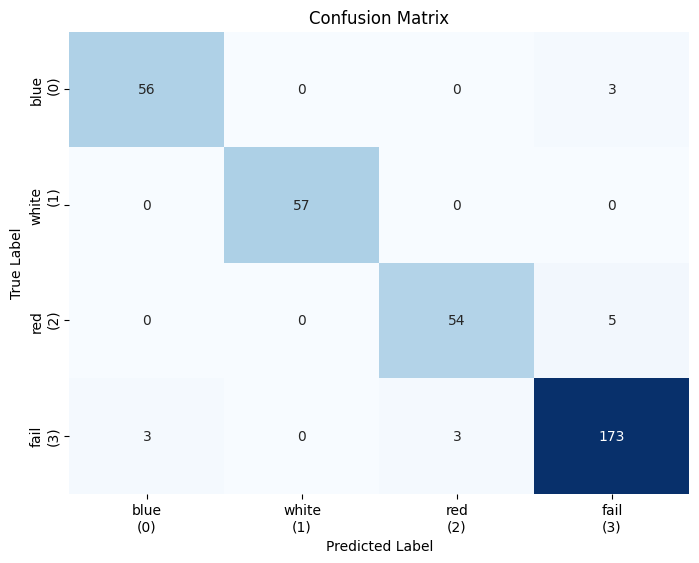

In [13]:
# Import necessary libraries
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Initialize lists for true and predicted labels
y_true = []
y_pred = []
images = []

# Iterate through the test dataset to collect true and predicted labels
for x, y in test_ds:
    y_true.extend(y.numpy())
    y_pred.extend(model.predict(x).argmax(axis=1))

    images.extend(x["image_input"].numpy())

# Convert y_true from one-hot encoding to class indices
y_true = np.argmax(y_true, axis=1)

# Generate the classification report as a dictionary
report = classification_report(y_true, y_pred)
print(report)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

# Set tick labels to class names
tick_labels = [f'{class_names[i]}\n({i})' for i in range(len(class_names))]
plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=tick_labels)
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=tick_labels)

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Save the confusion matrix plot
plt.savefig(os.path.join(plot_dir, 'confusion_matrix.png'))

plt.show()

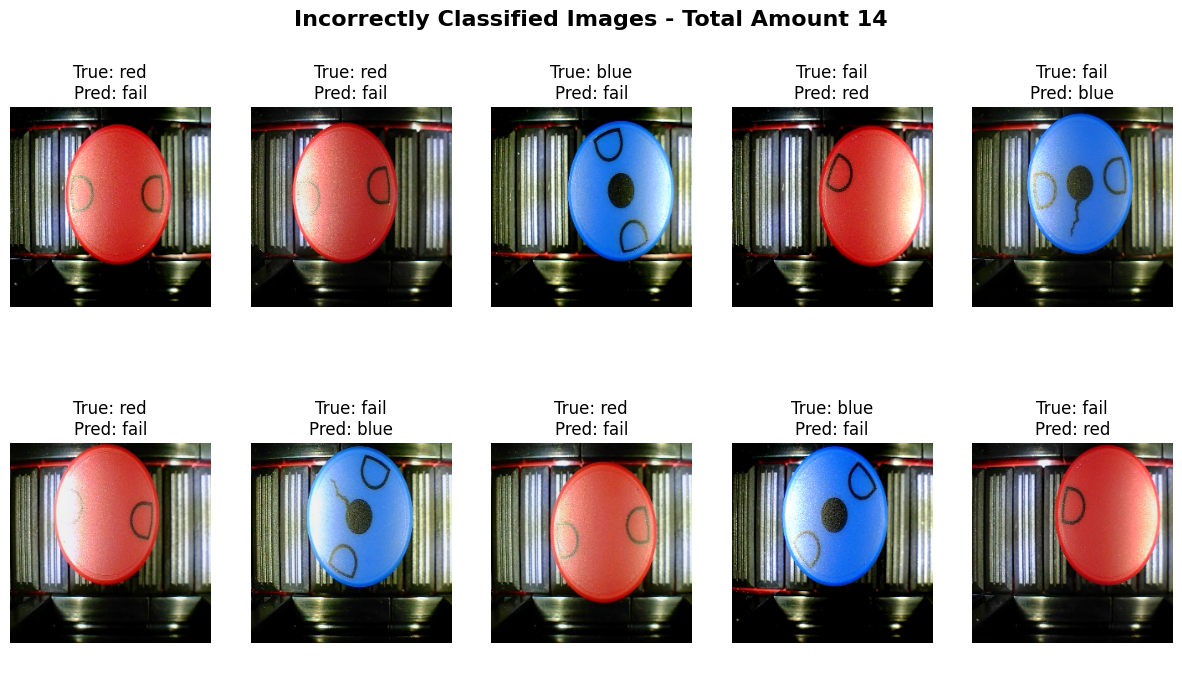

In [14]:
# Find and display incorrectly classified images
incorrect_indices = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]

# Plot some of the incorrectly classified images
num_images = 10  # Number of images to display
plt.figure(figsize=(15, 8))
plt.title(f'Incorrectly Classified Images - Total Amount {len(incorrect_indices)}', fontsize=16, fontweight='bold', pad=30)
plt.axis("off")
for i, idx in enumerate(incorrect_indices[:num_images]):
    plt.subplot(2, num_images // 2, i + 1)
    plt.imshow(images[idx].astype("uint8"), cmap='gray' if GRAYSCALE else None)
    plt.title(f'True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}')
    plt.axis('off')

# Save the plot
plt.savefig(os.path.join(plot_dir, 'incorrectly_classified_images.png'))

plt.show()

In [15]:
# Compute Recall for each class
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
recall_dict = dict(zip(class_names, recall))
print("Recall for each class:")
print(recall_dict)

Recall for each class:
{'blue': 0.9491525423728814, 'white': 1.0, 'red': 0.9152542372881356, 'fail': 0.9664804469273743}


In [16]:
# Compute Precision for each class
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
precision_dict = dict(zip(class_names, precision))
print("\nPrecision for each class:")
print(precision_dict)


Precision for each class:
{'blue': 0.9491525423728814, 'white': 1.0, 'red': 0.9473684210526315, 'fail': 0.9558011049723757}


1/1 [==============================] - 0s 24ms/step


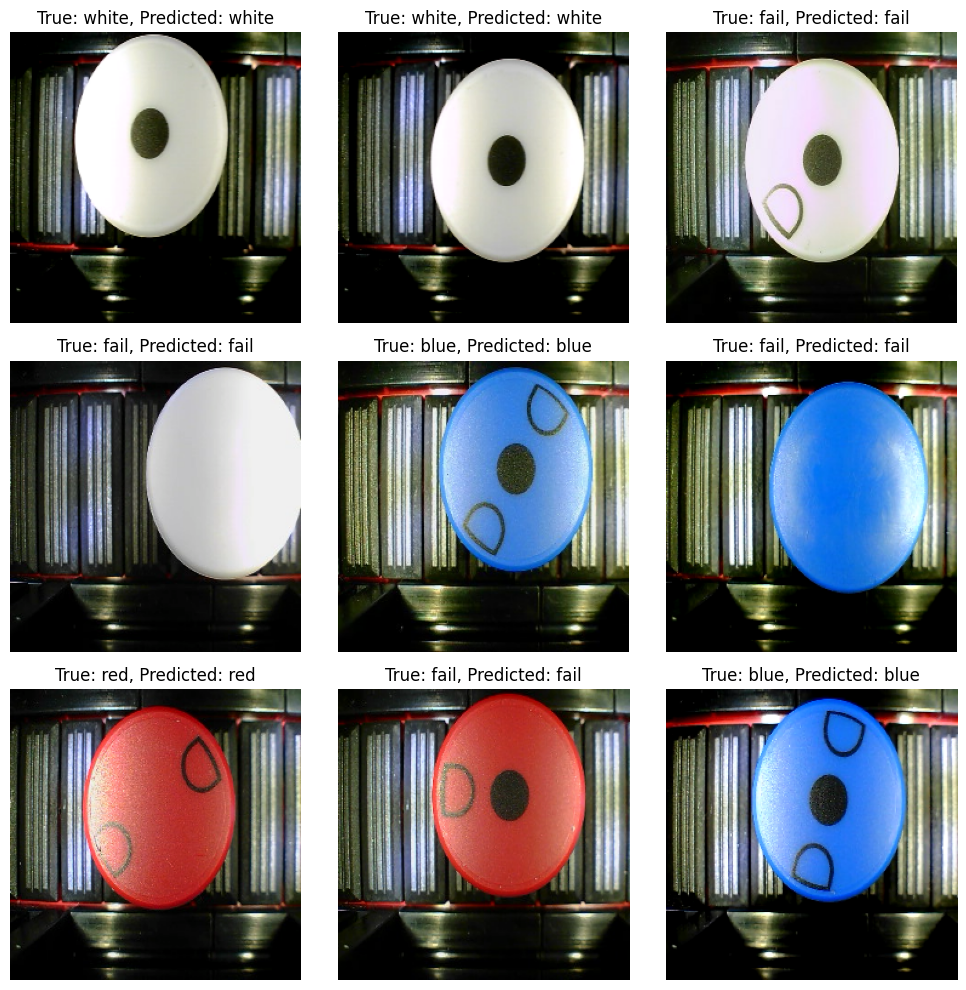

In [17]:
for x, y in test_ds.take(1):
    # Perform inference on the test data
    predictions = model.predict(x)
    # Get the class with the highest probability
    predicted_classes = np.argmax(predictions, axis=1)
    # Get the true classes
    true_classes = np.argmax(y, axis=1)

    # Display the images with the true and predicted classes
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(x["image_input"][i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[true_classes[i]]}, Predicted: {class_names[predicted_classes[i]]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [18]:

def convert_to_tflite(model, tflite_model_path):
    # Convert the model to the TensorFlow Lite format
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the model to disk
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)

v1_path = 'models/efficient_net.tflite'
v2_path = 'models/efficient_net_v2.tflite'

# Convert the model to TensorFlow Lite
convert_to_tflite(efficient_net, v1_path)
convert_to_tflite(efficient_net_v2, v2_path)

INFO:tensorflow:Assets written to: /tmp/tmpkyf7efg_/assets


INFO:tensorflow:Assets written to: /tmp/tmpkyf7efg_/assets
2024-06-10 22:42:42.546495: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-06-10 22:42:42.546532: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-06-10 22:42:42.546795: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpkyf7efg_
2024-06-10 22:42:42.562445: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-06-10 22:42:42.562458: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpkyf7efg_
2024-06-10 22:42:42.594933: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-06-10 22:42:42.612196: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-06-10 22:42:43.002955: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

INFO:tensorflow:Assets written to: /tmp/tmp05c3qfqv/assets


INFO:tensorflow:Assets written to: /tmp/tmp05c3qfqv/assets
2024-06-10 22:43:03.578769: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-06-10 22:43:03.578809: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-06-10 22:43:03.578962: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp05c3qfqv
2024-06-10 22:43:03.609374: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-06-10 22:43:03.609391: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp05c3qfqv
2024-06-10 22:43:03.690675: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-06-10 22:43:04.166334: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp05c3qfqv
2024-06-10 22:43:04.341297: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


blue: 0.00%
white: 0.00%
red: 0.00%
fail: 1.00%


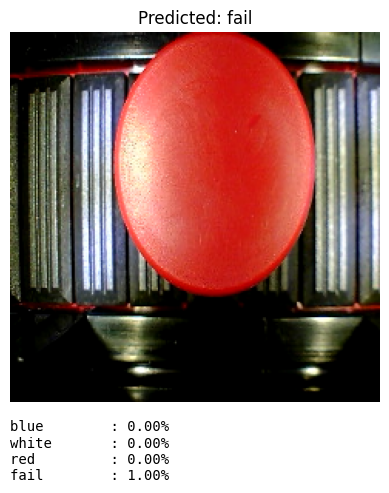

blue: 0.77%
white: 0.00%
red: 0.00%
fail: 0.23%


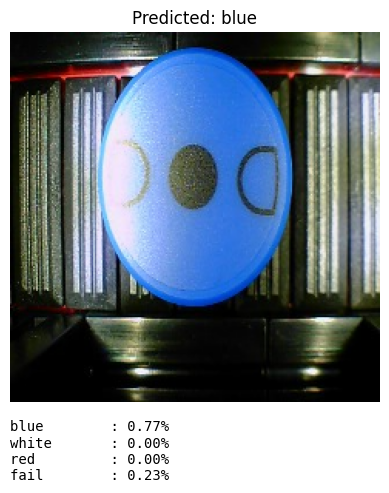

In [19]:
from controller.lib.TFLiteModel import TFLiteModel
import matplotlib.pyplot as plt
import numpy as np
import os

# Load the TFLite model and define the class names
efficient_net_tflite = TFLiteModel(v1_path)
efficient_net_v2_tflite = TFLiteModel(v2_path)

def plot_tflite_inference(tflite_model, name, class_names, plot_dir):
    for x, y in test_ds.take(1):
        image = x["image_input"][0].numpy()
        color = x["color_index_input"][0].numpy()

        image = image.astype(np.float32)  # Convert to FLOAT32

        # Convert color to float32
        color = color.astype(np.float32)
        # Convert color to 1D array
        color = np.expand_dims(color, axis=0)
        # Convert image to 4D array
        image = np.expand_dims(image, axis=0)

        # Perform inference using the TFLite model
        predictions = tflite_model.predict(color, image)

        # Print predictions annotated with class names
        for i, class_name in enumerate(class_names):
            print(f"{class_name}: {predictions[0][i]:.2f}%")

        # Get the class with the highest probability
        predicted_class = np.argmax(predictions)

        # Display the image with the predicted class
        plt.figure()
        plt.imshow(image[0].astype("uint8"))
        plt.title(f"Predicted: {class_names[predicted_class]}")
        plt.axis("off")

        # Display prediction accuracies below the plot with padding and formatting
        text = '\n'.join([f"{class_names[i]:<12}: {predictions[0][i]:.2f}%" for i in range(len(class_names))])
        plt.text(0, -0.05, text, transform=plt.gca().transAxes, fontsize=10, fontfamily='monospace', verticalalignment='top')

        # Save plot
        plt.savefig(os.path.join(plot_dir, f'{name}_inference.png'))

        plt.show()

# Plot the inference results for the EfficientNetB0 TFLite model
plot_tflite_inference(efficient_net_tflite, "efficient_net_tflite", class_names, plot_dir)

# Plot the inference results for the EfficientNetV2B0 TFLite model
plot_tflite_inference(efficient_net_v2_tflite, "efficient_net_tflite_v2", class_names, plot_dir)


In [20]:

def compare_inference_time(tflite_model, class_names):
    # Collect the predictions
    predictions = []
    test_labels = []

    time_start = time.time()

    for x, y in test_ds:
        for i in range(len(y)):
            image = x["image_input"][i].numpy()
            color = x["color_index_input"][i].numpy()

            image = image.astype(np.float32)  # Convert to FLOAT32

            # Convert color to float32
            color = color.astype(np.float32)
            # Convert color to 1D array
            color = np.expand_dims(color, axis=0)
            # Convert image to 4D array
            image = np.expand_dims(image, axis=0)

            output = tflite_model.predict(color, image)

            predictions.append(output)
            test_labels.append(y[i])

    # Calculate the accuracy
    correct = 0
    total = len(test_labels)

    for i in range(total):
        if np.argmax(predictions[i]) == np.argmax(test_labels[i]):
            correct += 1

    tflite_accuracy = correct / total

    time_end = time.time()

    print(f"TFLite Model Accuracy: {tflite_accuracy:.4f}")
    print(f"Time taken: {time_end - time_start:.4f} seconds")

# Compare inference time for EfficientNetB0 TFLite model
compare_inference_time(efficient_net_tflite, class_names)

# Compare inference time for EfficientNetV2B0 TFLite model
compare_inference_time(efficient_net_v2_tflite, class_names)

TFLite Model Accuracy: 0.9576
Time taken: 44.7359 seconds
TFLite Model Accuracy: 0.9605
Time taken: 23.1990 seconds
